# <center>Метод Эйлера<center>
# $$\frac{dx}{dt} = f(x, t)$$
# $$ \tau = (t_i - t_{i-1}) $$
# $$k=f(x_{i-1}, t_{i-1})$$
# $$x_i = x_{i-1} + \tau k$$

In [1]:
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

In [2]:
plt.rc('font', size=20)

In [3]:
def commutator(a, b):
    return a*b - b*a


def anti_commutator(a, b):
    return a*b + b*a


def lindbladian(*, A, gamma=0):
    return lambda ro: gamma * (A*ro*A.H - 0.5*anti_commutator(A.H*A, ro))


def fun(*, A, gamma=0):
    return lambda ro: lindbladian(A=A, gamma=gamma)(ro)


def ERK1(*, ro_0, H, A, gamma, grid):
    F = fun(A=A, gamma=gamma)

    step = grid[1] - grid[0]

    U = np.matrix(spl.expm(-1j*H*step))

    result = [ro_0]

    for _ in range(len(grid)-1):
        ro = result[-1]
        ro = U * ro * U.H
        k = F(ro)
        ro = ro + step*k
        result.append(ro)

    return result

## Пример - JC(1)

In [4]:
w = 10**10
g = 10**8
gamma = 10**5
T = 10**-4
N = 10**3
grid = np.linspace(0, T, N)

In [5]:
phi_0 = np.matrix([
    [0],
    [0],
    [1],
]).astype(np.complex128)

ro_0 = phi_0*phi_0.H

H = np.matrix([
    [0, 0, 0],
    [0, w, g],
    [0, g, w]
]).astype(np.complex128)

A = np.matrix([
    [0, 1, 0],
    [0, 0, 0],
    [0, 0, 0],
]).astype(np.complex128)

In [6]:
%%time

ro = ERK1(
    ro_0=ro_0,
    H=H,
    A=A,
    gamma=gamma,
    grid=grid,
)

CPU times: user 194 ms, sys: 22.3 ms, total: 216 ms
Wall time: 73.3 ms


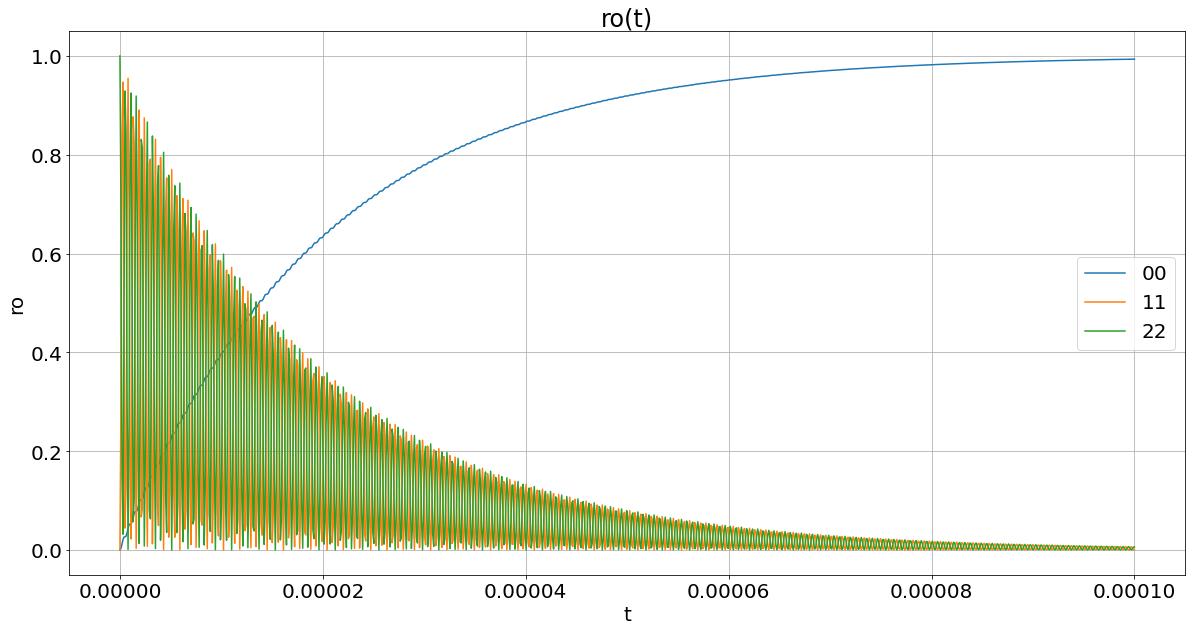

In [7]:
ro00 = [ro[0,0].real for ro in ro]
ro11 = [ro[1,1].real for ro in ro]
ro22 = [ro[2,2].real for ro in ro]

plt.figure(figsize=(20,10))
plt.title("ro(t)")
plt.ylabel("ro")
plt.xlabel("t")
plt.plot(grid, ro00)
plt.plot(grid, ro11)
plt.plot(grid, ro22)
plt.grid()
plt.legend(["00", "11", "22"])
plt.show()

# Sparse

In [8]:
def ERK1(*, ro_0, H, A, gamma, grid):
    ro_0 = ssp.csc_matrix(ro_0)
    H = ssp.csc_matrix(H)
    A = ssp.csc_matrix(A)

    F = fun(A=A, gamma=gamma)

    step = grid[1] - grid[0]

    U = spl.expm(-1j*H*step)

    result = [ro_0]

    for _ in range(len(grid)-1):
        ro = result[-1]
        ro = U * ro * U.H
        k = F(ro)
        ro = ro + step*k
        result.append(ro)

    return [np.matrix(ro.toarray()) for ro in result]

## Пример - JC(n)

In [9]:
w = 10**10
g = 10**8
gamma = 10**6
T = 10**-5
n = 101
N = 10**3
grid = np.linspace(0, T, N)

In [10]:
phi_0 = np.matrix(np.zeros((n+1, 1))).astype(np.complex128)
phi_0[-1, -1] = 1
ro_0 = phi_0*phi_0.H


H = np.matrix(np.zeros((n+1, n+1))).astype(np.complex128)
H[range(n+1), range(n+1)] = w * (np.arange(n+1) // 2 + np.arange(n+1) % 2)
H[range(1, n+1), range(n+1-1)] = g * np.sqrt(np.arange(n+1-1))
H[range(n+1-1), range(1, n+1)] = g* np.sqrt(np.arange(n+1-1))

A = np.matrix(np.zeros((n+1, n+1))).astype(np.complex128)
A[range(n+1-1), range(1, n+1)] = np.sqrt(np.arange(1, n+1))

In [ ]:
%%time

ro = ERK1(
    ro_0=ro_0,
    H=H,
    A=A,
    gamma=gamma,
    grid=grid,
)

In [ ]:
plt.figure(figsize=(20,10))
plt.title("diagonal ro")
plt.ylabel("diagonal ro")
plt.xlabel("i")
plt.plot(range(n+1), np.array(ro[-1]).diagonal().real)
plt.grid()
plt.show()

In [ ]:
np.sum(ro[-1].diagonal())  # checking solution

In [ ]:
x = range(n+1)

fig, ax = plt.subplots(figsize=(10,5))
plt.title("diagonal ro")
plt.ylabel("diagonal ro")
plt.xlabel("i")
line, = ax.plot([])
ax.set_xlim(-0.05, n+1)
ax.set_ylim(-0.05, 1)

def animate(frame_num):
    y = np.array(ro[frame_num]).diagonal().real
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=N, interval=10)
plt.close()

In [ ]:
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()